## 2D Non-circulant Deconvolution with cupy or numpy

The tnia test image collection is available [here](https://www.dropbox.com/scl/fo/1k3ujlh3lmk1pmnvpk3xb/h?dl=0&rlkey=ettx2705lvs25ywyrrcjujf0x) and the image used in this example is under 'deconvolution\hela-cells'.  The image was cropped from the green channel of the ImageJ sample image 'HeLa cells'.

This example shows how to use the cupy or numpy version of the nd-non-circulant decon on a 2D image.  Non-circulant deconvolution isn't ussually quite as important for 2D biological images (because XY extend of PSFs are ussually smaller then Z extent) however as seen in this example the non-circulant approach fixes ringing at the edges. 


## Create an environment and install dependencies

In this environment we will install some tools we need for decon, devbio version of Napari for visualization (which also installs jupyter notebook), sdeconv for theoretical PSF, tnia-python for numpy and cupy deconvolution code and XYZ projected figures in the notebook. 

```
    conda create --name decon-env python=3.9
    conda activate decon-env
    pip install devbio-napari
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install napari-sdeconv
```

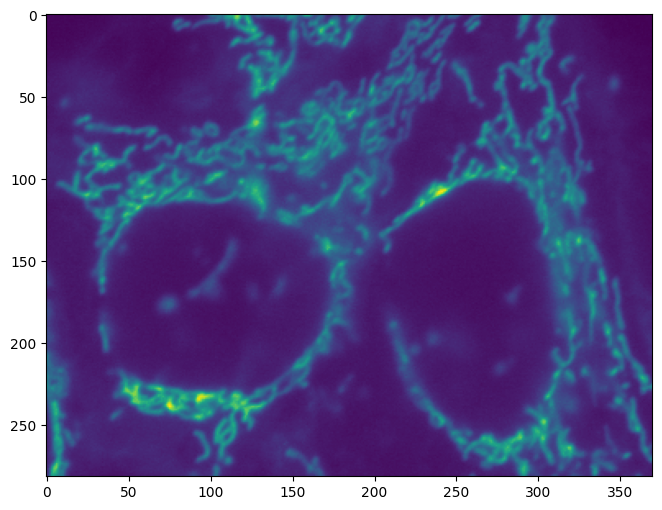

In [4]:
from skimage.io import imread
from tnia.plotting.plt_helper import imshow2d

im_name = r"D:\images\tnia-python-images\deconvolution\hela-cells\C2-hela-cells-cropped.tif"
im = imread(im_name)
im = im.astype('float32')

fig = imshow2d(im)


## Generate a PSF

I don't know exact values for the acquisition parameters of this image.  Thus I am simply creating a ad-hoc blur function with 'approximately' the blur I see in the image.  

gaussian (121, 121)


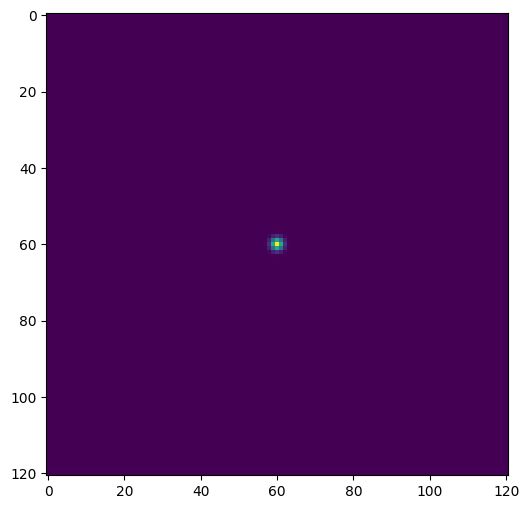

In [27]:
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.deconvolution.gaussian_psf import gaussian_2d
import numpy as np

psf_type = 'gibson-lanni'
psf_type = 'gaussian'

xy_psf_dim = 33


if psf_type == 'gibson-lanni':
    NA=1
    x_voxel_size = .07
    z_voxel_size = 1.0
    z_psf_dim=1
    ni=1.5
    ns=1.5
    wavelength = 0.4
    defocus = 0

    psf  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, defocus, wavelength)
    psf = np.squeeze(psf.astype('float32'))
elif psf_type == 'gaussian':
    psf = gaussian_2d(xy_psf_dim, 1)

print(psf_type, psf.shape)
fig = imshow2d(psf)

## Deconvolve the image using either numpy or cupy

Cupy is faster but require Nvidia/Cuda support.  In particular recent Macs do not have Cuda support as they use a custom chip set.  In that case try numpy. 

padding psf

0 10 20 30 40 50 60 70 80 90 

0 10 20 30 40 50 60 70 80 90 


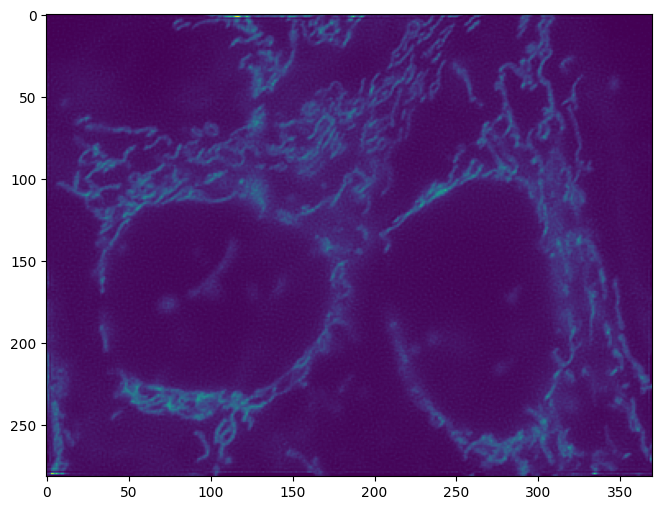

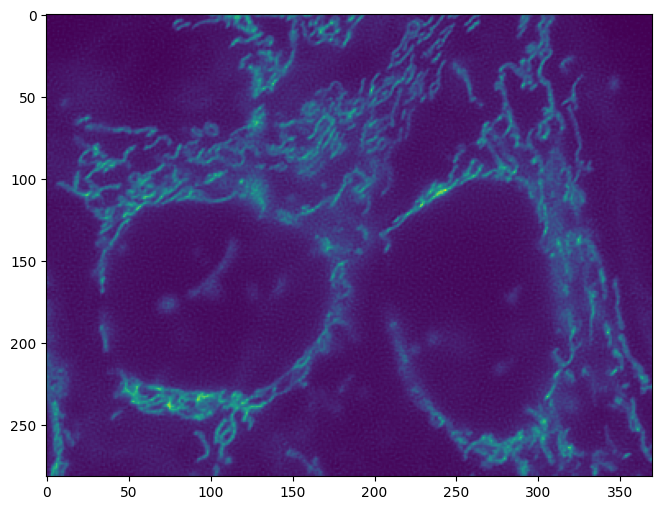

In [28]:
from tnia.deconvolution.psfs import gaussian_2d

im = im-im.min()

iterations = 50

use_cupy = True 

if use_cupy:
    from tnia.deconvolution.richardson_lucy import richardson_lucy_cp
    deconvolved = richardson_lucy_cp(im, psf, num_iters=100)
    deconvolved_nc = richardson_lucy_cp(im, psf, num_iters=100, noncirc=True)
else:
    from tnia.deconvolution.richardson_lucy_np import richardson_lucy_np
    deconvolved = richardson_lucy_np(im, psf, num_iters=100)
    deconvolved_nc = richardson_lucy_np(im, psf, num_iters=100, noncirc=True)

fig = imshow2d(deconvolved)
fig = imshow2d(deconvolved_nc)


## Otsu thresholding

Otsu thresholding is a good way to determine if the deconvolution is actually helpful.  A good deconvolution will improve contrast and lead to better separation of objects after thresholding

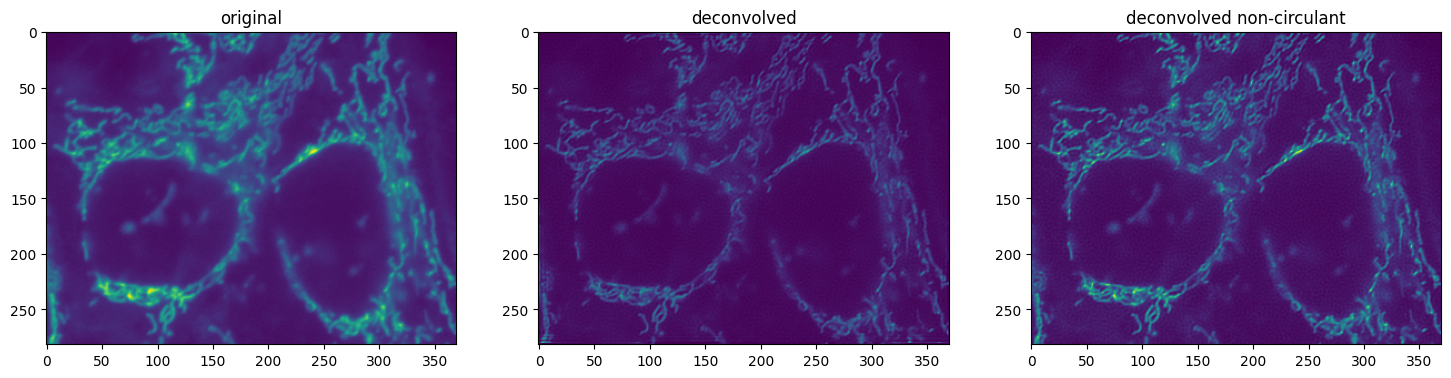

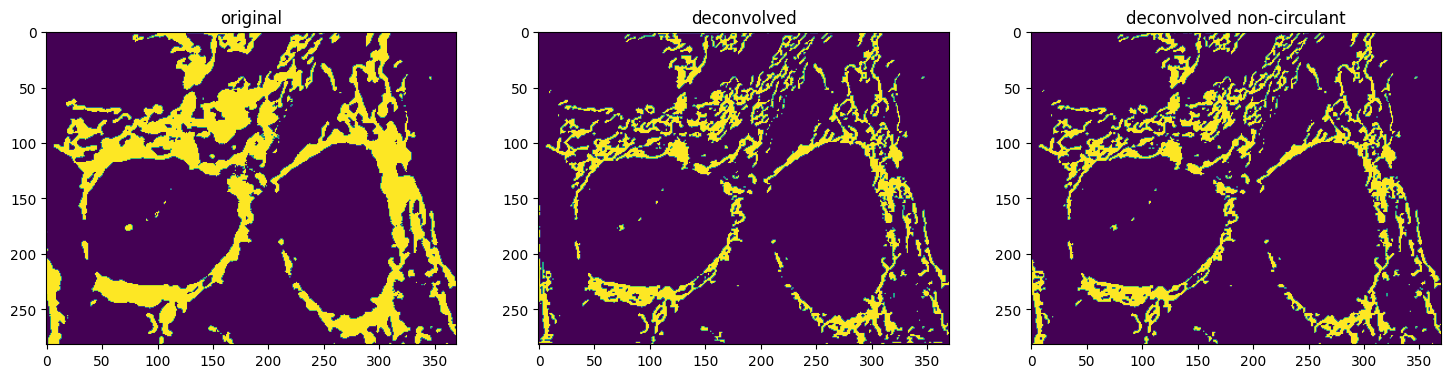

In [119]:
## Otsu threshold on the deconvolved image
from tnia.plotting.plt_helper import imshow_multi2d

from skimage.filters import threshold_otsu
thresholded = im>threshold_otsu(im)
thresholded_decon = deconvolved>threshold_otsu(deconvolved)
thresholded_decon_nc = deconvolved_nc>threshold_otsu(deconvolved_nc)

decons = [im, deconvolved, deconvolved_nc]
threshes = [thresholded, thresholded_decon, thresholded_decon_nc]
titles = ['original', 'deconvolved', 'deconvolved non-circulant']
fig = imshow_multi2d(decons, titles, 1, 3, 18, 8)
fig = imshow_multi2d(threshes, titles, 1, 3, 18, 8)


## Look at detail near the edges

Look closely at detail near the edges and we can see the non-circulant deconvolution reduced ringing near the edge.

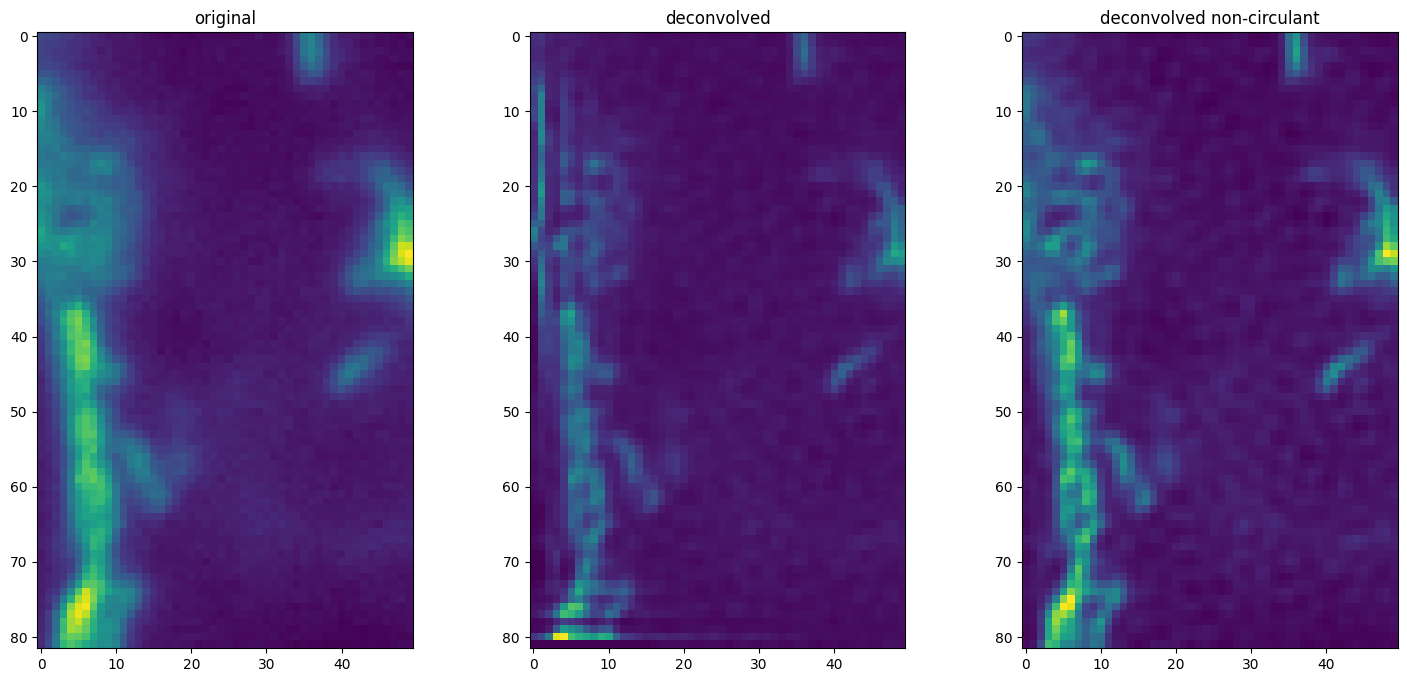

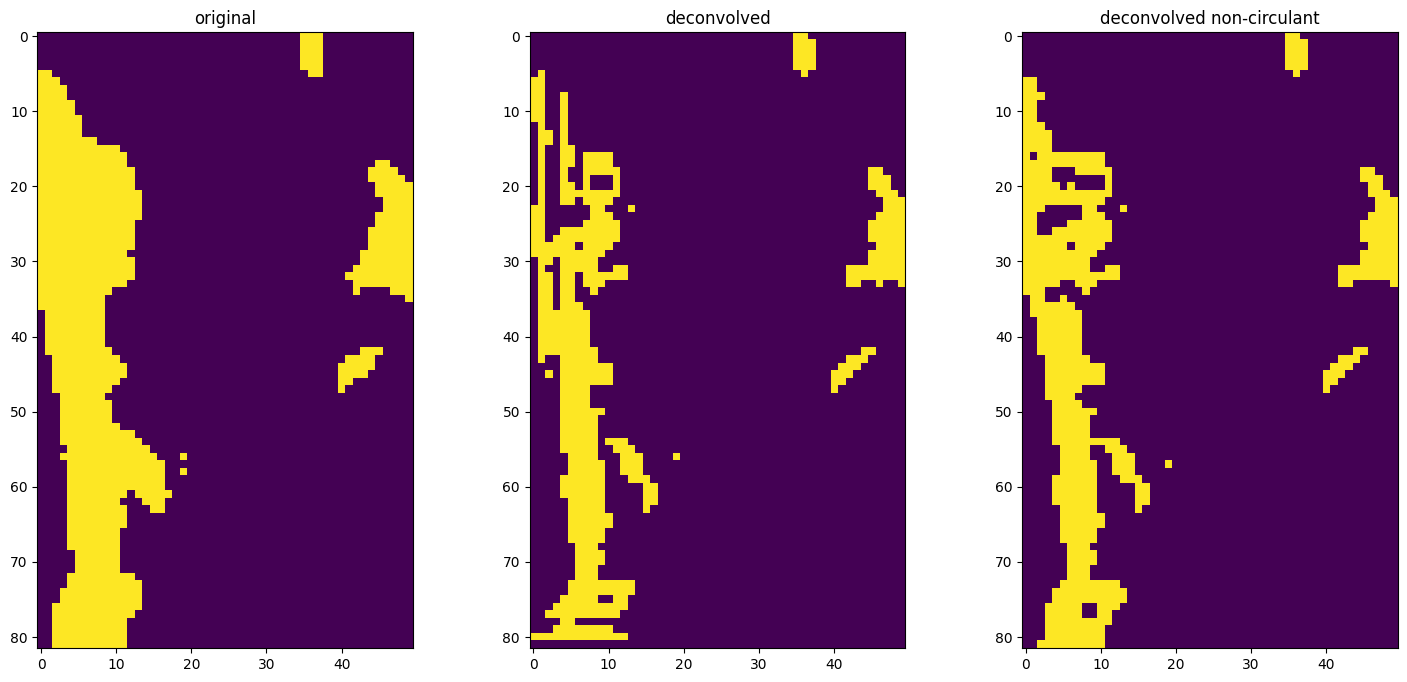

In [120]:
ind = np.s_[200:,0:50]

decons = [im[ind], deconvolved[ind], deconvolved_nc[ind]]
threshes = [thresholded[ind], thresholded_decon[ind], thresholded_decon_nc[ind]]
titles = ['original', 'deconvolved', 'deconvolved non-circulant']
fig = imshow_multi2d(decons, titles, 1, 3, 18, 8)
fig = imshow_multi2d(threshes, titles, 1, 3, 18, 8)

## Take a look in Napari

In [104]:
import napari
viewer = napari.Viewer()
viewer.add_image(im, name='im')
viewer.add_image(deconvolved, name='deconvolved')
viewer.add_image(deconvolved_nc, name='deconvolved_nc')
viewer.add_image(thresholded, name='thresholded')
viewer.add_image(thresholded_decon, name='thresholded_decon')
viewer.add_image(thresholded_decon_nc, name='thresholded_decon_nc')

<Image layer 'thresholded_decon_nc' at 0x211c6e9df70>